# Lead Conversion Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# Step 1: Load and Inspect Data

## Load the dataset and perform initial inspection

In [4]:
data = pd.read_csv('Leads.csv')
print("Dataset Loaded. Shape:", data.shape)
data.info()

Dataset Loaded. Shape: (9240, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Vis

# Step 2: Data Cleaning

## Replace 'Select' with NaN and drop columns with > 40% missing values

In [6]:
data.replace('Select', np.nan, inplace=True)
columns_to_drop = [
    'How did you hear about X Education', 'Lead Profile', 'Lead Quality',
    'Asymmetrique Profile Score', 'Asymmetrique Activity Score',
    'Asymmetrique Activity Index', 'Asymmetrique Profile Index'
]
data.drop(columns=columns_to_drop, inplace=True)

## Impute missing values

In [10]:
# Impute missing values
data.loc[:, data.select_dtypes(include='number').columns] = data.select_dtypes(include='number').fillna(data.median(numeric_only=True))
for col in data.select_dtypes(include='object').columns:
    data.loc[:, col] = data[col].fillna(data[col].mode()[0])

# Combine rare categories in 'Country' into 'Other'

In [12]:
rare_countries = data['Country'].value_counts()[data['Country'].value_counts() < 10].index
data['Country'] = data['Country'].replace(rare_countries, 'Other')

## Drop irrelevant or unique identifier columns

In [14]:
data.drop(columns=['Prospect ID'], inplace=True)

# Step 3: Exploratory Data Analysis (EDA)

## Target Variable Distribution

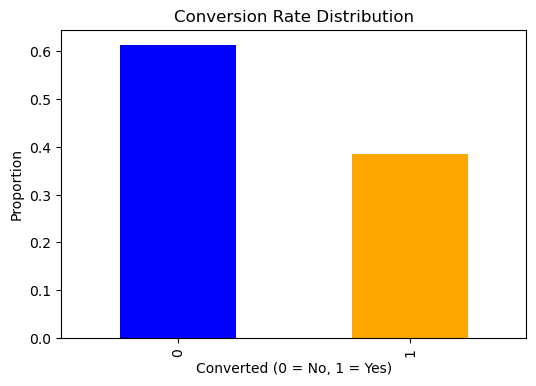

In [16]:
plt.figure(figsize=(6, 4))
data['Converted'].value_counts(normalize=True).plot(kind='bar', color=['blue', 'orange'])
plt.title('Conversion Rate Distribution')
plt.xlabel('Converted (0 = No, 1 = Yes)')
plt.ylabel('Proportion')
plt.show()

## Correlation Matrix

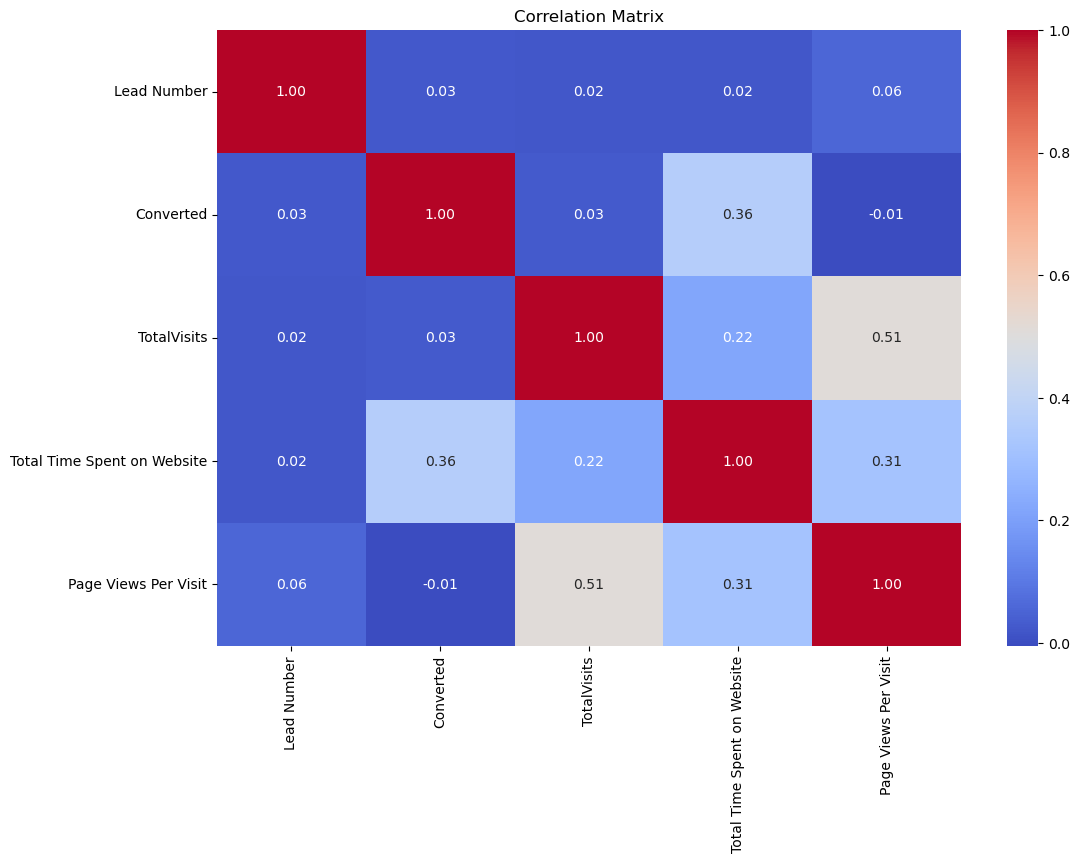

In [20]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
correlation = data.select_dtypes(include=[np.number]).corr()  # Select only numeric columns
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Insights from Correlation Matrix

In [23]:
print("Insights: Total Time Spent on Website and Conversion show strong positive correlation, indicating its importance in predicting lead conversion.")

Insights: Total Time Spent on Website and Conversion show strong positive correlation, indicating its importance in predicting lead conversion.


## Pairplot for Numeric Features

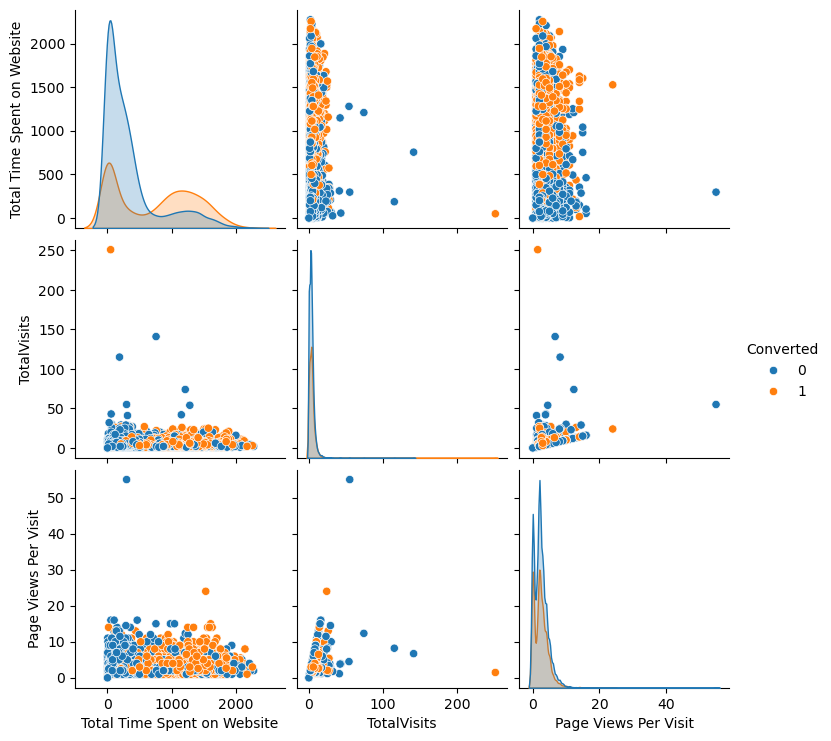

In [25]:
numeric_features = ['Total Time Spent on Website', 'TotalVisits', 'Page Views Per Visit']
sns.pairplot(data, vars=numeric_features, hue='Converted')
plt.show()

## Insights from Pairplot

In [28]:
print("Insights: Leads with higher Total Time Spent on Website and Total Visits tend to show higher conversion rates.")

Insights: Leads with higher Total Time Spent on Website and Total Visits tend to show higher conversion rates.


# Step 4: Feature Engineering

## Interaction Terms

In [30]:
interaction_feature = data['Total Time Spent on Website'] * data['TotalVisits']
data['Interaction_TotalTime_Visits'] = interaction_feature

## Context on Interaction Feature

In [33]:
print("The interaction term Interaction_TotalTime_Visits combines two important features, capturing non-linear relationships between time spent and visits.")

The interaction term Interaction_TotalTime_Visits combines two important features, capturing non-linear relationships between time spent and visits.


## Encode categorical variables

In [35]:
data_encoded = pd.get_dummies(data, drop_first=True)

# Step 5: Splitting the Data

In [37]:
X = data_encoded.drop(columns=['Converted'])
y = data_encoded['Converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Step 6: Data Scaling

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 7: Logistic Regression with Hyperparameter Tuning

In [43]:
logistic_model = LogisticRegression(random_state=42, max_iter=5000)  # Increase max_iter to 5000
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_logistic_model = grid_search.best_estimator_
print("Best Logistic Regression Parameters:", grid_search.best_params_)

# Logistic Regression Evaluation
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
y_pred_proba_logistic = best_logistic_model.predict_proba(X_test_scaled)[:, 1]
logistic_auc = roc_auc_score(y_test, y_pred_proba_logistic)
print("Logistic Regression AUC:", logistic_auc)

# Cross-Validation for Logistic Regression
cv_scores_logistic = cross_val_score(best_logistic_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("Logistic Regression Cross-Validation AUC:", cv_scores_logistic.mean())

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logistic))
print("Classification Report:")
print(classification_report(y_test, y_pred_logistic))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression AUC: 0.9516586880835574
Logistic Regression Cross-Validation AUC: 0.954380705033618
Confusion Matrix:
[[1582  122]
 [ 165  903]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1704
           1       0.88      0.85      0.86      1068

    accuracy                           0.90      2772
   macro avg       0.89      0.89      0.89      2772
weighted avg       0.90      0.90      0.90      2772



# Step 8: Random Forest with Cross-Validation

In [46]:
rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10, min_samples_split=5)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

## Cross-Validation for Random Forest

In [49]:
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Random Forest Cross-Validation AUC:", cv_scores_rf.mean())

Random Forest Cross-Validation AUC: 0.9528915591785729


## Random Forest Evaluation

In [51]:
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, y_pred_proba_rf)
print("Random Forest AUC:", rf_auc)

Random Forest AUC: 0.9506066910200277


# Step 9: Gradient Boosting with Cross-Validation

In [54]:
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=200, learning_rate=0.1, max_depth=5)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=200, random_state=42)

## Cross-Validation for Gradient Boosting

In [57]:
cv_scores_gb = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='roc_auc')
print("Gradient Boosting Cross-Validation AUC:", cv_scores_gb.mean())

Gradient Boosting Cross-Validation AUC: 0.9615907154664459


## Gradient Boosting Evaluation

In [60]:
y_pred_gb = gb_model.predict(X_test)
y_pred_proba_gb = gb_model.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test, y_pred_proba_gb)
print("Gradient Boosting AUC:", gb_auc)

Gradient Boosting AUC: 0.960558489827856


# Step 10: Model Comparison and ROC Curve

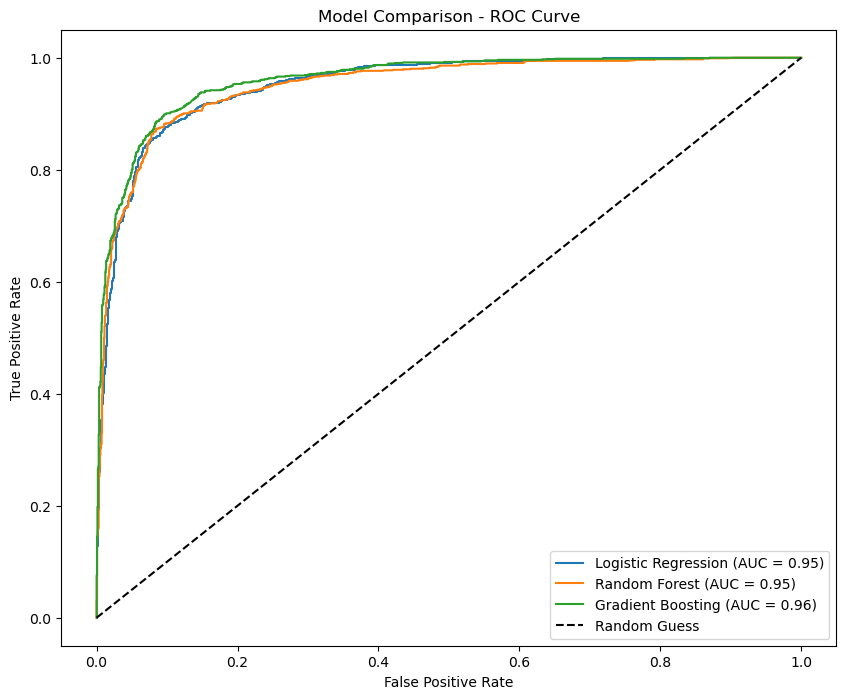

In [63]:
plt.figure(figsize=(10, 8))
for model_name, proba, label in zip([
    'Logistic Regression', 'Random Forest', 'Gradient Boosting'
], [y_pred_proba_logistic, y_pred_proba_rf, y_pred_proba_gb], [
    'Logistic Regression', 'Random Forest', 'Gradient Boosting'
]):
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Comparison - ROC Curve')
plt.legend()
plt.show()

## Feature Importance for Random Forest

In [65]:
feature_importance_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top Features from Random Forest:")
print(feature_importance_rf.head(10))

Top Features from Random Forest:
                                               Feature  Importance
2                          Total Time Spent on Website    0.137572
4                         Interaction_TotalTime_Visits    0.094698
103           Tags_Will revert after reading the email    0.088330
127                     Last Notable Activity_SMS Sent    0.078061
42                              Last Activity_SMS Sent    0.063938
6                            Lead Origin_Lead Add Form    0.063107
98                                        Tags_Ringing    0.061937
86                             Tags_Closed by Horizzon    0.048360
76   What is your current occupation_Working Profes...    0.047238
75          What is your current occupation_Unemployed    0.032613
